In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yasen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv("Tweets.csv")
df = df[['text', 'airline_sentiment']]
df.dropna(inplace=True)

# Keep only 3 classes
df = pd.read_csv("Tweets.csv")
df = df[['text', 'airline_sentiment']]
df.dropna(inplace=True)
df = df[df['airline_sentiment'].isin(['positive', 'neutral', 'negative'])]

# Classified
df_pos = df[df['airline_sentiment'] == 'positive']
df_neg = df[df['airline_sentiment'] == 'negative']
df_neu = df[df['airline_sentiment'] == 'neutral']

# Downsample negative to size of positive
df_neg_downsampled = resample(df_neg,
                              replace=False,
                              n_samples=len(df_pos),
                              random_state=42)

# Merging
df = pd.concat([df_pos, df_neg_downsampled, df_neu])

print(df['airline_sentiment'].value_counts())

neutral     3099
positive    2363
negative    2363
Name: airline_sentiment, dtype: int64


In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|@\S+|[^a-z\s]", "", text)  # убираем ссылки, упоминания и не-буквы
    words = [word for word in text.split() if len(word) > 2 and word not in stop_words]
    return " ".join(words)

df['clean_text'] = df['text'].apply(clean_text)


In [5]:
X = df['clean_text']
y = df['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [6]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    stop_words='english',
    min_df=3,
    max_df=0.95,
    sublinear_tf=True
)


X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [7]:
model = LinearSVC(class_weight='balanced')
model.fit(X_train_tfidf, y_train)


C:\Users\yasen\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(class_weight='balanced')

              precision    recall  f1-score   support

    negative       0.69      0.67      0.68       473
     neutral       0.69      0.68      0.69       620
    positive       0.71      0.74      0.72       472

    accuracy                           0.70      1565
   macro avg       0.70      0.70      0.70      1565
weighted avg       0.70      0.70      0.70      1565



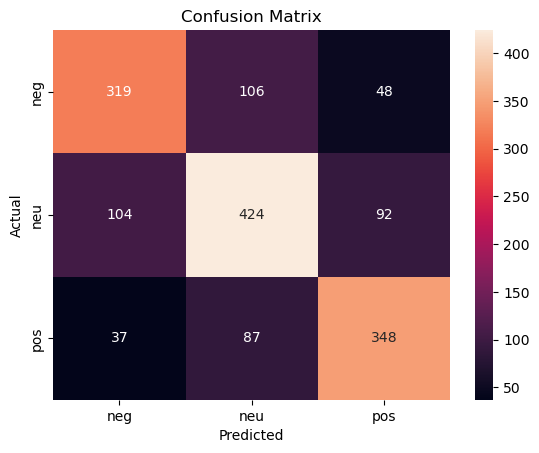

In [8]:
y_pred = model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

conf = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])
sns.heatmap(conf, annot=True, fmt='d', xticklabels=['neg', 'neu', 'pos'], yticklabels=['neg', 'neu', 'pos'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


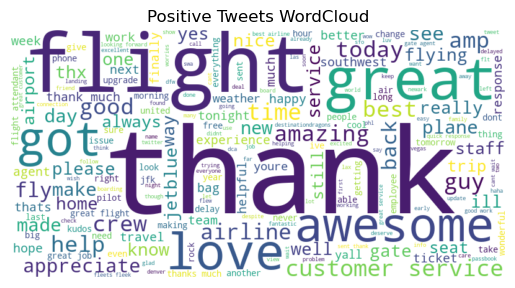

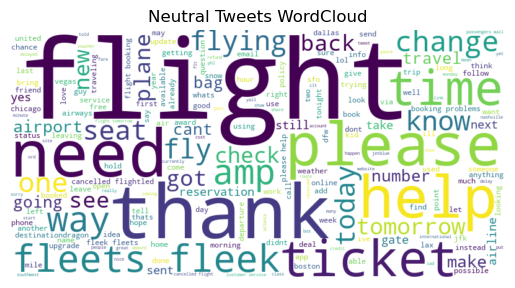

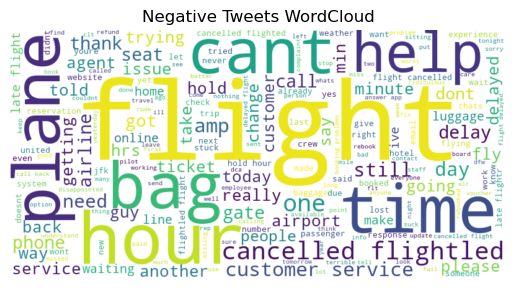

In [9]:
for sentiment in ['positive', 'neutral', 'negative']:
    text = " ".join(df[df['airline_sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment.capitalize()} Tweets WordCloud")
    plt.show()
